In [3]:
# Basic Imports
from glob import glob
import os
import shutil 
from tqdm.autonotebook import tqdm
import pandas as pd
from pandas import read_csv
import os
import math
import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import time
import datetime
import pathlib
from plotly.offline import plot
from plotly import graph_objs as go

from __future__ import division
import warnings
warnings.filterwarnings("ignore")

def plot_spectrum(Data, Peaks, assignments = None):
    
        """ 
        Function which plots the spectrum, peaks, and peaks assigned (optional).
        
        Parameters
        ----------
        Data: Pandas DataFrame
            Full spectrum of the data as a Pandas DataFrame with 3 columns (Frequency [MHz], Flux [Any units], SNR [SNR]). 
            
        Peaks: Pandas DataFrame
            List of peaks as a Pandas DataFrame with 3 columns (Frequency [MHz], Peak Frequencies [MHz], SNR [SNR]). 
        
       assigments: Pandas DataFrame
            Pandas dataframe containing the spectral assignment information (Molecule, Frequency, Catalog_Frequency, Catalog_Intensity,
            Intensity, Lower_State_Energy, Upper_State_Energy, and Uncertainty).
            
        Returns
        -------
        An interactive Bokeh plot containing the full spectrum, peaks, and assigned peaks. 
        """
        
        
        fig = go.FigureWidget()

        fig.layout["xaxis"]["title"] = "Frequency (MHz)"
        fig.layout["xaxis"]["tickformat"] = ".,"
        fig.layout["yaxis"]["title"] = str('SNR')

        fig.add_scattergl(
            x=Data['Frequency'],
            y=Data['SNR'],
            name="Experiment",
            opacity=0.6,
        )

        amplitudes = Peaks['SNR']
        centers = Peaks['Frequency']
        # Add sticks for U-lines
        fig.add_bar(
            x=centers, y=amplitudes, hoverinfo="text", name="Peaks"
        )
        
        if assignments is not None:
            
            amplitudes = assignments['Intensity']
            centers = assignments['Frequency']
            molecules = assignments['Molecule']
            
            fig.add_bar(
            x=centers, y=amplitudes, hoverinfo="text", name="Assigned Peaks"
        )
        #plot(fig, filename='file.html')

        return fig

# Create a function to text me when peak assignment process is done running

def send_sms(dt, phone_number = '+17035771654'):
    
    """ 
        Function texts the user when the peak assignment process is finished with the time elapsed.
        
        Parameters
        ----------
        dt: str
            Time elapsed for peak assignment process. 
        phone_numer: str
            Phone number to text when peak assignment is finished
        
        Returns
        -------
        A text to the user when the peak assignment process is finished. 
    """
    
    #auth credentials 
    account_sid = "AC2891f9f537bc42ba8b2ea4d093c889d8"
    auth_token = '594c95bfe1c930ef66cdd6e0d1d5cd28'
    
    # Create client object
    client = Client(account_sid, auth_token)

    # Send text to client
    message = client.messages.create(
                                body='Peak Assignment is finished. Time elapsed: '+ dt,
                                from_='+19497873575',
                                to= phone_number
                            )
    return message.sid

# This program assumes you have a folder full of .cat files with molecular names (e.g. H2O.cat)
   # This program will allow you to take those .cat files and sort them into a folder based on 
   # their composition (e.g. a folder with only molecules with C & H)
   
   # 2 inputs required
   
       # 1.) A path to the main folder full of all .cat files (variable: master_path)
       
       # 2.) A string containing all the elements you want your new folder to contain
           # Use upper case, no spaces, and only one string (variable = elements)(ex. 'CHODN')
# This program assumes you have a folder full of .cat files with molecular names (e.g. H2O.cat)
    # This program will allow you to take those .cat files and sort them into a folder based on 
    # their composition (e.g. a folder with only molecules with C & H)
    
    # 2 inputs required
    
        # 1.) A path to the main folder full of all .cat files (variable: master_path)
        
        # 2.) A string containing all the elements you want your new folder to contain
            # Use upper case, no spaces, and only one string (variable = elements)(ex. 'CHODN')    
            

# This program assumes you have a folder full of .cat files you wish to store
    # in a new directory file .yaml or .yml (These are both YAML file suffixes)
    # Providing 3 inputs, will allow the user to create a yaml file for a folder full of 
    # .cat molecules
    
    # 1.) A file path describing the folder hosting all the .cat files you wish to be 
        # written into your new yaml file (variable: master_path)
    
    # 2.) A file path describing where you wish your new YAML to be stored (variable: yaml_path)
    
    # 3.) A name for your new YAML file (variable: yaml_file_name)
        # The yaml_file_name should be all the elements present in the folder of molecules 
        # followed by .yaml or .yml (ex. CHODN.yaml if the master_path = ../CHODN_list/)

def write_yaml(yaml_directory_path, yaml_entry):
    """ 
        Function which writes and appends a yaml file.
        
        Parameters
        ----------
        yaml_entry: str
            Yaml entry for a single molecular catalogue, including the molecular name and filepath to the catalogue. 
        
        Returns
        -------
        Appends the current YAML directory file. 
    """ 
    with open(yaml_directory_path, 'a') as f:
        yaml.dump(yaml_entry, f)

def create_yaml(master_path, yaml_path, yaml_file_name):
    
    """ 
        Function which takes in a filepath to a folder full of molecular catalogues and creates a yaml directory which describes
        each molecules name and filepath.
        
        Parameters
        ----------
        master_path: str
            Filepath to molecular catalogues of interest. 
        yaml_path: str
            Filepath to save the yaml directory file.
        yaml_file_name: str
            Filename for yaml directory file.
            
        Returns
        -------
        yaml_directory_path: str
            Filepath to the saved the yaml directory. 
    """
    
    # Redefine the subdirectory containing all .cats of interest
    
    master_path = master_path +'/'
    
    # Creates a list of all molecules based on the files in the master_path

    list_of_files = sorted(filter(os.path.isfile, glob(master_path + '*.cat')))
    
    # Remove old yaml if it exists
    
    yaml_directory_path = yaml_path+yaml_file_name
    
    if os.path.exists(yaml_directory_path):
            os.remove(yaml_directory_path)

    # This loop goes through the list of files and writes the yaml file for all molecules

    for file in range(len(list_of_files)):
        molecule_current = list_of_files[file][len(master_path):-4]
        molecule_current_path = master_path + molecule_current+'.cat'

        # Each .cat file in the list is appended to a .yaml in this format

        # Example:

        # CH3OH:
            # formula: CH3OH
            # filepath: /Users/joshuabardwell/Desktop/NASA/Code/Catalogues/master_list/CHODN_list/CH3OH.cat

        # DO NOT EDIT THE FORMAT BELOW! PySpecTools needs the YAML file in this format to process each catalogue

        yaml_entry = {
                str(molecule_current): {
                    'formula':str(molecule_current),
                    'filepath': str(molecule_current_path)
                }
        }
        write_yaml(yaml_directory_path, yaml_entry)
    
    print('\033[1m' + '\n YAML directory successfully created! Proceed to step 3.' + '\033[0m')
        
    return yaml_directory_path


def create_element_folder(master_path, elements):
    
    """ 
        Function which takes in a filepath to all molecular catalogues and creates a subfolder with only the elements of interest.
        
        Parameters
        ----------
        master_path: str
            Filepath to all molecular catalogues. 
        elements: str
            String which contains all elements of interest (elements which your sample consists of e.g 'CHO') 
         
        Returns
        -------
        cat_path: str
            Filepath to the subdirectory which contains the molecular catalogues which only contains elements which
            the original sample consisted of. 
    """
    
    # Reset and clear the old file path folder if it exists
    if os.path.exists(master_path+elements +'_list'):
        shutil.rmtree(master_path+elements +'_list')
        
    # This function creates a new folder within the master_path to populate based on the elements specified

    cat_path = os.path.join(master_path,elements +'_list')

    if not os.path.exists(cat_path):
        os.mkdir(cat_path)

    # Creates a list of .cat files from the main folder hosting all .cat files

    list_of_files = sorted(filter(os.path.isfile, glob(master_path + '*')))

    element_set = set(elements+"0123456789abcdefghijklmnopqrstuvwxyz,+=-/()' ")
    
    # Main for loop for sifting through files and creating the new folder

    for file in range(len(list_of_files)):

        # Defines the current molecule being analyzed
        molecule_current = list_of_files[file][len(master_path):-4]

        # Defines the current file path to that molecule
        molecule_current_path = master_path+"/"+molecule_current+'.cat'

        #Defines the new file path for the molecule to go to if applicable
        molecule_new_path = cat_path+"/"+molecule_current+'.cat'

        # Finds if the molecule only has elements specified
        if set(molecule_current).issubset(element_set):

            # Sifts through all possible exceptions in periodic table
            if 'Cs' in molecule_current:
                print('Cs found:',molecule_current)
            elif 'Ca' in molecule_current:
                print('Ca found:',molecule_current)
            elif 'Cr' in molecule_current:
                print('Cr found:',molecule_current)
            elif 'Co' in molecule_current:
                print('Co found:',molecule_current)
            elif 'Cu' in molecule_current:
                print('Cu found:',molecule_current)
            elif 'Cd' in molecule_current:
                print('Cd found:',molecule_current)
            elif 'Cn' in molecule_current:
                print('Cn found:',molecule_current)
            elif 'Cl' in molecule_current:
                print('Cl found:',molecule_current)
            elif 'Ce' in molecule_current:
                print('Ce found:',molecule_current)
            elif 'Cm' in molecule_current:
                print('Cm found:',molecule_current)
            elif 'Cf' in molecule_current:
                print('Cf found:',molecule_current)        


            elif 'Hf' in molecule_current:
                print('Hf found:',molecule_current)
            elif 'Hg' in molecule_current:
                print('Hg found:',molecule_current)
            elif 'He' in molecule_current:
                print('He found:',molecule_current)
            elif 'Ho' in molecule_current:
                print('Ho found:',molecule_current)
            elif 'Hf' in molecule_current:
                print('Hf found:',molecule_current)
            elif 'Hg' in molecule_current:
                print('Hg found:',molecule_current)
            elif 'He' in molecule_current:
                print('He found:',molecule_current)
            elif 'Ho' in molecule_current:
                print('Ho found:',molecule_current)


            elif 'Os' in molecule_current:
                print('Os found:',molecule_current)
            elif 'Og' in molecule_current:
                print('Og found:',molecule_current)


            elif 'Na' in molecule_current:
                print('Na found:',molecule_current)
            elif 'Ni' in molecule_current:
                print('Ni found:',molecule_current)
            elif 'Nh' in molecule_current:
                print('Nh found:',molecule_current)  
            elif 'Nb' in molecule_current:
                print('Nb found:',molecule_current)
            elif 'Ne' in molecule_current:
                print('Ne found:',molecule_current)
            elif 'Nd' in molecule_current:
                print('Nd found:',molecule_current)
            elif 'Np' in molecule_current:
                print('Np found:',molecule_current)
            elif 'No' in molecule_current:
                print('No found:',molecule_current)

            elif 'Db' in molecule_current:
                print('Db found:',molecule_current)
            elif 'Ds' in molecule_current:
                print('Ds found:',molecule_current)
            elif 'Dy' in molecule_current:
                print('Dy found:',molecule_current)    

            # Sifts through files which were named unconventionally (ex. Cyclopropenone)
            elif 'ne' in molecule_current:
                print('unknown molecule:',molecule_current)
            elif 'ol' in molecule_current:
                print('unknown molecule:',molecule_current)
            elif 'al' in molecule_current:
                print('unknown molecule:',molecule_current)
            elif 'ate' in molecule_current:
                print('unknown molecule:',molecule_current)
            elif 'acid' in molecule_current:
                print('unknown molecule:',molecule_current)
            elif 'ether' in molecule_current:
                print('unknown molecule:',molecule_current)

            else:
                # If the program didn't find any exceptions then it copies the .cat file to the new folder 
                shutil.copy(molecule_current_path,molecule_new_path)
    
    print('\033[1m' + f'\n Subdirectory of catalogues only containing {elements} created. Proceed to next line to create a YAML dircetory for these catalogues.' + '\033[0m')
    
    return cat_path

def read_yaml(yaml_filepath):
    with open(yaml_filepath) as read_file:
        yaml_dict = yaml.load(read_file, Loader=yaml.Loader)
    return yaml_dict
                     
def parse_cat(simulation_path, low_freq=0.0, high_freq=np.inf, threshold=-np.inf, cat_max_uncertainty = np.inf, temperature = 300):
    """ 
        Function which parses the molecular catalogue and returns Pandas DataFrame within the parameter limits specified by the user.
        
        Parameters
        ----------
        cat_path: str
            Filepath to a molecular catalogue. 
        min_freq: float, optional
            Minimum frequency [MHz] to consider when filtering through the catalogue dataframe. 
        max_freq: float, optional
            Maximum frequency [MHz] to consider when filtering through the catalogue dataframe.
        thres: float
            Minimum log intensity to consider when filtering through the catalogue dataframe.
        cat_max_uncertainty: float
            Maximum catalogue uncertainty to consider when filtering through the catalogue dataframe.
        temperature: float
            Assumed temperature, in Kelvin, of the experiment to determine what lower state energy
            to consider when filtering through the catalogue dataframe.
         
        Returns
        -------
        catalog_df: Pandas DataFrame
            Pandas DataFrame for a molecular catalogue, containing peaks which are within the frequency range specified, less than the minimum
            log intensity, less than the max catalogue uncertainty, less than the lower state energy (3*temperature [wavenumber]).
    """
    cat_df = pd.read_fwf(
        simulation_path,
        widths=[13, 8, 8, 2, 10, 3, 7, 4, 2, 2, 2, 8, 2, 2],
        header=None,
        names = [
        "Frequency",
        "Uncertainty",
        "Intensity",
        "DoF",
        "Lower state energy",
        "Degeneracy",
        "ID",
        "Coding",
        "N'",
        "F'",
        "J'",
        "N''",
        "F''",
        "J''",
    ])

    cat_df = cat_df[
        (cat_df["Frequency"].astype(float) >= low_freq)
        & (  # threshold the simulation output
            cat_df["Frequency"].astype(float) <= high_freq
        )
        & (  # based on user specified values
            cat_df["Intensity"].astype(float) >= threshold
        )  # or lack thereof
        & (  # based on user specified values
            cat_df["Uncertainty"].astype(float) <= cat_max_uncertainty
        )
        & (  # based on user specified values
            cat_df["Lower state energy"].astype(float) <= 3*temperature
        )
    ]
    return cat_df

def read_cat(cat_path, min_freq = 0, max_freq = np.inf, thres = -10.0, cat_max_uncertainty = 0.1, temperature = 300):
    
    """ 
        Function which takes in a filepath to a molecular catalogue, reads the data as a Pandas DataFrame, and filters
        the dataframe to fit the parameters set by the user.
        
        Parameters
        ----------
        cat_path: str
            Filepath to a molecular catalogue. 
        min_freq: float, optional
            Minimum frequency [MHz] to consider when filtering through the catalogue dataframe. 
        max_freq: float, optional
            Maximum frequency [MHz] to consider when filtering through the catalogue dataframe.
        thres: float
            Minimum log intensity to consider when filtering through the catalogue dataframe.
        cat_max_uncertainty: float
            Maximum catalogue uncertainty to consider when filtering through the catalogue dataframe.
        temperature: float
            Assumed temperature, in Kelvin, of the experiment to determine what lower state energy
            to consider when filtering through the catalogue dataframe.
         
        Returns
        -------
        catalog_df: Pandas DataFrame
            Pandas DataFrame for a molecular catalogue, containing peaks which are within the frequency range specified, less than the minimum
            log intensity, less than the max catalogue uncertainty, less than the lower state energy (3*temperature [wavenumber]).
    """
    
    catalog_df = parse_cat(cat_path, low_freq=min_freq, high_freq=max_freq, threshold = thres, cat_max_uncertainty = cat_max_uncertainty, temperature = temperature*0.6950356)
        
    #columns = ["N'", "J'", "N''", "J''"]
    #catalog_df["qno"] = catalog_df[columns].apply(
        #lambda x: "N'={}, J'={} - N''={}, J''={}".format(*x), axis=1
    #)
    # Create a formatted quantum number string
    # catalog_df["qno"] = "N'={}, J'={} - N''={}, J''={}".format(
    #    *catalog_df[["N'", "J'", "N''", "J''"]].values
    # )
    # Calculate E upper to have a complete set of data
    
    # GET BACK TO FIGURING OUT UPPER STATE ENERGY
    
    #catalog_df["Upper state energy"] = units.calc_E_upper(
        #catalog_df["Frequency"], catalog_df["Lower state energy"]
    #)
    return catalog_df

def get_assignment_statistics(assignments ,identity_threshold = 3):  
    
    """ 
        Function which provides statistics on the molecular assignments made (Number of lines per molecule histogram, list of unique molecules 'identified', 
        percentage of molecules containing certain elements, etc.)
        Parameters
        ----------
        assigments: Pandas DataFrame
            Pandas dataframe containing the spectral assignment information (Molecule, Frequency, Catalog_Frequency, Catalog_Intensity,
            Intensity, Lower_State_Energy, Upper_State_Energy, and Uncertainty).
        identity_threshold: float
            Number of lines to consider prior to labeling the molecule as an 'identified'.
        
        Returns
        -------
        A series of assignment statistics including:
            - Number of molecular assignments made
            - Number of unique peaks assigned
            - Number of, and a list of molecules which were assigned to a peak
            - Number of, and a list of molecules which were 'identified'
            - Histogram showing the number of peaks assigned per molecule assigned
            - The percentage breakdown of molecules which contain:
                - Carbon (C), Hydrogen (H), Oxygen (O), Deuterium (D), and Nitrogen (N)
            - The percentage breakdown of molecules which only contain:
                - CH, CHO, CHOD, or CHODN
    """
    
    # This block performs some analysis on the assignments made to determine the number of unique molecules and number of 
    # identifications made based on a theshold value defined below

    identity_threshold = identity_threshold # This value is the number of lines needed to be present for the program to consider the molecule
                           # a true identification. The default value is 3 lines but may be changed

    n_molecules = assignments['Molecule'].nunique() # This operand counts the number of unique molecules discovered

    unique_molecules = list(assignments['Molecule'].unique()) # This creates a list of unique molecules 
    identified_molecules = [unique_molecules[molecule] for molecule in range(len(unique_molecules)) if #identifies molecules based
                assignments['Molecule'].value_counts()[unique_molecules[molecule]]>=identity_threshold]# on threshold value defined

    bold_start = '\033[1m'
    bold_end = '\033[0m'

    # This block finds what percentage of unique molecules contain C, H, O, D, or N

    C_list = [unique_molecules[molecule] for molecule in range(len(unique_molecules)) if 'C' in unique_molecules[molecule]]
    C_fract = (len(C_list)/len(unique_molecules))

    H_list = [unique_molecules[molecule] for molecule in range(len(unique_molecules)) if 'H' in unique_molecules[molecule]]
    H_fract = (len(H_list)/len(unique_molecules))

    O_list = [unique_molecules[molecule] for molecule in range(len(unique_molecules)) if 'O' in unique_molecules[molecule]]
    O_fract = (len(O_list)/len(unique_molecules))

    D_list = [unique_molecules[molecule] for molecule in range(len(unique_molecules)) if 'D' in unique_molecules[molecule]]
    D_fract = (len(D_list)/len(unique_molecules))

    N_list = [unique_molecules[molecule] for molecule in range(len(unique_molecules)) if 'N' in unique_molecules[molecule]]
    N_fract = (len(N_list)/len(unique_molecules))

    CH_fract = (C_fract)*(H_fract)*(1-O_fract)*(1-D_fract)*(1-N_fract)
    CHO_fract = (C_fract)*(H_fract)*(O_fract)*(1-D_fract)*(1-N_fract)
    CHOD_fract = (C_fract)*(H_fract)*(O_fract)*(D_fract)*(1-N_fract)
    CHODN_fract = (C_fract)*(H_fract)*(O_fract)*(D_fract)*(N_fract)

    atom_list = pd.Series({'C':C_fract,'H':H_fract,'O':O_fract,'D':D_fract,'N':N_fract})

    # The lines below prints the results with a bar chart of the molecules and the number lines counted 

    print(bold_start + 'Number of Molecular Assignments:' + bold_end, len(assignments['Frequency']))
    print('\n')
    print(bold_start + 'Number of Unique Assigned Peaks:' + bold_end, assignments['Frequency'].nunique())
    print('\n')
    print(bold_start + 'Number of Unique Molecules Detected:' + bold_end, n_molecules)
    print('\n')
    print(bold_start + 'Names of Unique Molecules:' + bold_end, *unique_molecules, sep = '   ')
    print('\n')
    print(bold_start + 'Number of Identified Molecules Detected:' + bold_end, len(identified_molecules))
    print('\n')
    print(bold_start + 'Names of Identified Molecules:' + bold_end, *identified_molecules, sep = '   ')

    # Adjust 'figsize' parameter as needed below

    assignments['Molecule'].value_counts().plot.barh(color='b', title = 'Molecule Line Count', figsize=(5,10))
    plt.show()

    # Prints percentages of unique molecules containing C, H, O, D, or N

    print(bold_start + 'Percentage of Molecules with:' + bold_end+'\n')
    print('\t'+bold_start + 'C:' + bold_end, round(C_fract, 3)*100, '%')
    print('\t'+bold_start + 'H:' + bold_end, round(H_fract, 3)*100, '%')
    print('\t'+bold_start + 'O:' + bold_end, round(O_fract, 3)*100, '%')
    print('\t'+bold_start + 'D:' + bold_end, round(D_fract, 3)*100, '%')
    print('\t'+bold_start + 'N:' + bold_end, round(N_fract, 3)*100, '%')
    print('\n')
    print('\t'+bold_start+'Only CH:'+bold_end, round(CH_fract,3)*100, '%')
    print('\t'+bold_start+'Only CHO:'+bold_end, round(CHO_fract,3)*100, '%')
    print('\t'+bold_start+'Only CHOD:'+bold_end, round(CHOD_fract,3)*100, '%')
    print('\t'+bold_start+'Only CHODN:'+bold_end, round(CHODN_fract,3)*100, '%')

def calc_E_upper(cat_freq, cat_lower_energy):
    wavenumber = cat_freq / 29979.2458 # MHz to wavenumber
    return wavenumber + cat_lower_energy

def assign_peaks(Data, Peaks, yaml_filepath, intensity_tolerance = -10.0, cat_max_uncertainty = 0.1, temperature = 300*0.6950356, freq_offset = 1.5, 
                 peaks_now = False, special_molecule = '', special_intensity = -10.0):
    """ 
        Function which takes in a dataset, list of peaks, and yaml dictionary to assign peaks to molecular catalogs.
        
        Parameters
        ----------
        Data: Pandas DataFrame
            Full spectrum of the data as a Pandas DataFrame with 3 columns (Frequency [MHz], Flux [Any units], SNR [SNR]). 
            
        Peaks: Pandas DataFrame
            List of peaks as a Pandas DataFrame with 3 columns (Frequency [MHz], Peak Frequencies [MHz], SNR [SNR]). 
            
        yaml_filepath: str
            Filepath to a yaml dictionary which describes the molecular names and filepaths of catalogues.
            
        intensity_tolerance: float
            Value which represents the log intensity cutoff for molecular catalogues.
            
        cat_max_uncertainty: float
            Value which respresents the max uncertainty value for molecular catalogues.
            
        temperature: float
            Assumed value of the experiment's temperature in units of Kelvin to determine lower state energy cutoff in wavenumber.
            
        freq_offset: float
            Offset value, in units of MHz, from the catalogue center frequency to consider when assigning peaks to their molecular catalogue.
            
        peaks_now: bool, optional
            If True, a live update of assigned peaks will be provided to the user.
            
        special_molecule: str, optional
            Name of a single molecule which may have a unique log intensity cutoff, different than the intensity_tolerance previously
            provided.
            
        special_intensity: float, optional
            Value which represents a unique log intensity cutoff for a special molecule, to consider during the peak
            assignment process.
            
        Returns
        -------
        assigments: Pandas DataFrame
            Pandas dataframe containing the spectral assignment information (Molecule, Frequency, Catalog_Frequency, Catalog_Intensity,
            Intensity, Lower_State_Energy, Upper_State_Energy, and Uncertainty).
    """
    
    # Read in the yaml file which contains all .cat files
    
    yaml_dict = read_yaml(yaml_filepath)
    
    # Define minimum and maximum frequency to filter catalogues
    min_freq, max_freq = min(Data['Frequency']), max(Data['Frequency'])
    
    assignments = pd.DataFrame(columns = ['Molecule', 'Frequency', 'Catalog_Frequency', 'Catalog_Intensity', 'Intensity', 'Lower_State_Energy', 'Upper_State_Energy', 'Uncertainty'])
    
    bold_start = '\033[1m'
    bold_end = '\033[0m'
    
    formula = bold_start + 'Formula' + bold_end
    peak_frequency = bold_start + 'Peak Frequency' + bold_end
    
    start = time.time() # This starts a timer
    
    for name, subdict in tqdm(yaml_dict.items(), desc = 'Processing Molecular Peak Assignments'):
    #for name, subdict in yaml_dict.items():
        
        
        file_path, formula = subdict.items()
        file_path, formula = file_path[1], formula[1]
        
        if formula == special_molecule:
            cat_df = read_cat(file_path, min_freq = min_freq, max_freq = max_freq, thres = special_intensity, cat_max_uncertainty = cat_max_uncertainty, temperature = temperature)
            
        else:
            cat_df = read_cat(file_path, min_freq = min_freq, max_freq = max_freq, thres = intensity_tolerance, cat_max_uncertainty = cat_max_uncertainty, temperature = temperature)
        
        if len(cat_df) > 0:
            cat_df = cat_df.reset_index(drop = True)
            
            peak_index = -1
            
            for peak in Peaks['Frequency']:
                
                peak_index = peak_index + 1
                
                for index in range(len(cat_df['Frequency'])):
                    if abs(peak - cat_df['Frequency'][index]) <= freq_offset:
                        
                        if peaks_now == True:
                            print(f"\033[1mPeak Found:\033[0m {formula:<20}{peak:^15}")

                        upper_state_energy = calc_E_upper(cat_df["Frequency"][index], cat_df["Lower state energy"][index])
                        
                        assignments = assignments.append({'Molecule' : name, 'Frequency' : peak, 'Catalog_Frequency' : cat_df['Frequency'][index], 'Catalog_Intensity': cat_df['Intensity'][index],'Intensity' : Peaks['SNR'][peak_index], 'Lower_State_Energy' : cat_df["Lower state energy"][index],'Upper_State_Energy' : upper_state_energy, 'Uncertainty': cat_df['Uncertainty'][index]}, ignore_index=True)
    end = time.time() # This ends a timer
    dt = time.strftime('%H:%M:%S', time.gmtime(end - start))
    
    print('\033[1m' + f'\n Peaks found in step 4 have been assigned to their molecular catalogues! This assignment process took {dt}' + '\033[0m')
    return assignments, dt

def peak_find(spec_df: pd.DataFrame, freq_col="Frequency", int_col="Intensity",
              thres=0.015, min_dist=10):
    """ 
        Wrapper for peakutils applied to pandas dataframes. First finds
        the peak indices, which are then used to fit Gaussians to determine
        the center frequency for each peak.
        Parameters
        ----------
        spec_df: dataframe
            Pandas dataframe containing the spectrum information, with columns corresponding to frequency and intensity.
        freq_col: str, optional
            Name of the frequency column in `spec_df`
        int_col: str, optional
            Name of the intensity column in `spec_df`
        thres: float, optional
            Threshold for peak detection
        Returns
        -------
        peak_df: Pandas dataframe
            Pandas dataframe containing the peaks frequency/intensity
    """
    peak_indices = peakutils.indexes(
        spec_df[int_col].to_numpy(),
        thres=thres,
        thres_abs=True,
        min_dist=min_dist
        )
    frequencies = peakutils.interpolate(
        x=spec_df[freq_col].to_numpy(),
        y=spec_df[int_col].to_numpy(),
        ind=peak_indices,
        width=11
        )
    # Get the peaks if we were just using indexes
    direct_df = pd.DataFrame(spec_df).iloc[peak_indices]
    direct_df.reset_index(inplace=True)
    direct_freqs = direct_df[freq_col].values
    # Calculate the difference in fit vs. approximate peak
    # frequencies
    differences = np.abs(direct_df[freq_col] - frequencies)
    intensities = pd.DataFrame(spec_df).iloc[peak_indices][int_col].values
    peak_df = pd.DataFrame(
        data=list(zip(frequencies, direct_freqs, intensities)),
        columns=["Frequency", "Peak Frequencies", int_col]
        )
    # Take the indexed frequencies if the fit exploded
    # and deviates significantly from the original prediction
    peak_df.update(
        direct_df.loc[differences >= 0.2]
        )
    # Use 1sigma as the detection threshold; remove everything else!
    peak_df = peak_df.loc[
        peak_df[int_col] >= thres
        ]
    peak_df.reset_index(drop=True, inplace=True)
    
    return peak_df

def get_rms(data):
    """ 
        Function which determines the root mean square (RMS) of the noise region. The RMS of Gaussian white noise
        should be equal to the standard distribution, RMS is calculated just in case the noise is not Gaussian-white.
        
        Parameters
        ----------
        Data: Pandas DataFrame
            Pandas DataFrame Flux column.
        
        Returns
        -------
    
         RMS: float
            Root mean square of the noise.
    """
    RMS = np.sqrt(np.sum([i**2 for i in data])/len(data))
    return RMS

def get_power_spectra(data):
    """ 
        Function which takes in a dataset, which represents a sample of the noise, and computes the fast-fourier transform (FFT)
        power spectra to visualize the noise.
        
        Parameters
        ----------
        Data: Pandas DataFrame
            Pandas DataFrame Flux column.
        
        Returns
        -------
    
        Plot which shows the FFT power spectra of the flux in the noise region. 
    """
    
    data = np.array(data)
    ps = np.abs(np.fft.fft(data))**2

    time_step = 1 
    freqs = np.fft.fftfreq(data.size, time_step)
    idx = np.argsort(freqs)

    plt.loglog(freqs[idx], ps[idx])
    plt.xlabel('$Frequency \hspace{0.5} (Hz)$')
    plt.ylabel('Power Density')
    plt.show()
    
def get_datapaths(BASE_DIR):
    
    tree = pathlib.Path(BASE_DIR)

    # .rglob() produces a generator too
    tree.rglob("*.txt")

    # Which you can wrap in a list() constructor to materialize
    l = list(tree.rglob("*Broadband.txt"))

    print('Here are a list of your Broadband filepaths from your lwa\'s: \n')
    [print('\t',path, '\n') for path in l];
    
    
def get_data(data, thres_percentage = 0.01, sep = '\t'):   
    
    """ 
        Function which takes in the filepath for this session and converts the 'Flux' column to 'SNR' by determining the noise baseline.
        The function then returns the data as a dataframe with the 'SNR' column, root mean square (RMS) of the noise, and baseline estimation 
        of the noise. 
        
        Parameters
        ----------
        data: str
            Filepath to the experimental data in the form of a .txt with two columns (Frequency [MHz], Flux [Any units]).
        thres_percentage: float
            Threshold percentage of the largest peak in the dataset to determine the best sample of the, assumed, Gaussian-white noise in the data.
        sep: str
            Delimiter in the data file.
        
        Returns
        -------
        Data: Pandas DataFrame
            Pandas DataFrame with 3 columns (Frequency [MHz], Flux [Any units], SNR [SNR]). 
        rms: float
            Root mean square of the noise in the data.
        baseline: float
            Value which is the average of the noise, representing the baseline of the data. 
            
    """
    
    
    Data = pd.read_csv(data, names = ['Frequency', 'Flux'], delimiter = sep, skiprows = 1)
    
    threshold = thres_percentage*Data['Flux'].max()

    peaks_df = peak_find(
            Data,
            freq_col='Frequency',
            int_col='Flux',
            thres=threshold,
        )

    max_deficit_index = np.argmax(np.ediff1d(peaks_df['Frequency']))

    noise_region = peaks_df['Frequency'][max_deficit_index : max_deficit_index+2]
    
    Data = pd.DataFrame(Data)
    noise_data = Data[Data['Frequency'].between(*noise_region, inclusive = 'neither')]
    
    sample_size = len(noise_data)
    
    if sample_size < 100:
        print(f'Sample size of noise is {sample_size} which is statistically insignificant. Please increase your threshold percentage parameter.')
        return None, None, None
        
    
    plt.plot(Data['Frequency'], Data['Flux'])
    plt.scatter(peaks_df['Frequency'], peaks_df['Flux'], marker = 'x', color = 'r')
    plt.scatter(peaks_df['Frequency'][max_deficit_index], peaks_df['Flux'][max_deficit_index], marker = 'x', color = 'g')
    plt.scatter(peaks_df['Frequency'][max_deficit_index+1], peaks_df['Flux'][max_deficit_index+1], marker = 'x', color = 'g')
    plt.plot(noise_data['Frequency'], noise_data['Flux'])
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Flux')
    plt.show()
    
    plt.plot(Data['Frequency'], Data['Flux'])
    plt.scatter(peaks_df['Frequency'], peaks_df['Flux'], marker = 'x', color = 'r')
    plt.scatter(peaks_df['Frequency'][max_deficit_index], peaks_df['Flux'][max_deficit_index], marker = 'x', color = 'g')
    plt.scatter(peaks_df['Frequency'][max_deficit_index+1], peaks_df['Flux'][max_deficit_index+1], marker = 'x', color = 'g')
    plt.xlim(peaks_df['Frequency'][max_deficit_index]-10, peaks_df['Frequency'][max_deficit_index]+150) 
    plt.plot(noise_data['Frequency'], noise_data['Flux'])
    plt.ylim(-100, peaks_df['Flux'][max_deficit_index]+20) 
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Flux')
    plt.show()
    
    get_power_spectra(noise_data['Flux'])

    baseline = np.average(noise_data['Flux'])
    rms = get_rms(noise_data['Flux'])
    
    Data["SNR"] = Data['Flux'] / np.abs(baseline)
    
    Data = Data.reset_index(drop = True)
    
    print('\033[1m' + f'\nIf you are content with the results from this step, proceed to step 4. If not, alter your thres_percentage parameter until you are ready to proceed.' + '\033[0m')

    return Data, rms, baseline

def get_latex(assignments, Unassigned_Peaks, filename, save_path = '/Users/joshuabardwell/Desktop/NASA/Code/Assignments/'):
    
    """ 
        Function which takes in spectral assignments dataframe and converts it to a latex file which is saved in
        a specified filepath.
        
        Parameters
        ----------
        assigments: Pandas dataframe
            Pandas dataframe containing the spectral assignment information (Molecule, Frequency, Catalog_Frequency, Catalog_Intensity,
            Intensity, Lower_State_Energy, Upper_State_Energy, and Uncertainty).
        Unassigned_Peaks: Pandas DataFrame
            List of unassigned peaks as a Pandas DataFrame with 3 columns (Frequency [MHz], Peak Frequencies [MHz], SNR [SNR]).
        filename: str
            Name of the latex file name.
        save_path: str
            Specified filepath to save the latex file. 
        
        Returns
        -------
        latex_file
            Latex file containing the spectral assignments from this session. 
    """
    with open(save_path + filename+".tex",'a') as latex_file:
        latex_file.write(assignments.to_latex(index=False))
        latex_file.write(Unassigned_Peaks.to_latex(index=False))
    latex_file.close()
    print('\033[1m' + f'\nOutput latex file with assignments and unassigned peaks made. The output file has been saved in the lwa file\'s folder.') 
    print('Proceed to Step 6 for the Boltzmann analysis.' + '\033[0m')
    
    
def get_unassigned_peaks(assignments, Peaks):
    """ 
        Function which creates a list of the unassigned list of peaks by filtering the Peaks list with the assignments list.
        
        Parameters
        ----------
        assigments: Pandas dataframe
            Pandas dataframe containing the spectral assignment information (Molecule, Frequency, Catalog_Frequency, Catalog_Intensity,
            Intensity, Lower_State_Energy, Upper_State_Energy, and Uncertainty).
            
        Peaks: Pandas DataFrame
            List of peaks as a Pandas DataFrame with 3 columns (Frequency [MHz], Peak Frequencies [MHz], SNR [SNR]). 
        
        Returns
        -------
        Unassigned_Peaks: Pandas DataFrame
            List of unassigned peaks as a Pandas DataFrame with 3 columns (Frequency [MHz], Peak Frequencies [MHz], SNR [SNR]).
    """
    
    bold_start = '\033[1m'
    bold_end = '\033[0m'
    
    assignments['Frequency'] = assignments.Frequency.astype(float)
    
    Unassigned_Peaks = Peaks[~Peaks['Frequency'].isin(assignments['Frequency'])]
    
    print(bold_start + '\nNumber of Unassigned Peaks:' + bold_end, len(Unassigned_Peaks))
    
    return Unassigned_Peaks

def export_txt(Data, txt_name):
    tfile = open(txt_name + '.txt', 'a')
    tfile.write(Data.to_string())
    tfile.close()

/var/folders/cv/y25zbqt53rg624n2mzb0zskr0000gn/T/ipykernel_18487/1011308672.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import peakutils
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

import DataAnalysisProcedures_4 as dap
import importlib

def peak_find(spec_df: pd.DataFrame, freq_col="Frequency", int_col="Intensity",
              thres=0.015, min_dist=10):
    """ 
        Wrapper for peakutils applied to pandas dataframes. First finds
        the peak indices, which are then used to fit Gaussians to determine
        the center frequency for each peak.
        Parameters
        ----------
        spec_df: dataframe
            Pandas dataframe containing the spectrum information, with columns corresponding to frequency and intensity.
        freq_col: str, optional
            Name of the frequency column in `spec_df`
        int_col: str, optional
            Name of the intensity column in `spec_df`
        thres: float, optional
            Threshold for peak detection
        Returns
        -------
        peak_df: Pandas dataframe
            Pandas dataframe containing the peaks frequency/intensity
    """
    peak_indices = peakutils.indexes(
        spec_df[int_col].to_numpy(),
        thres=thres,
        thres_abs=True,
        min_dist=min_dist
        )
    frequencies = peakutils.interpolate(
        x=spec_df[freq_col].to_numpy(),
        y=spec_df[int_col].to_numpy(),
        ind=peak_indices,
        width=11
        )
    # Get the peaks if we were just using indexes
    direct_df = pd.DataFrame(spec_df).iloc[peak_indices]
    direct_df.reset_index(inplace=True)
    direct_freqs = direct_df[freq_col].values
    # Calculate the difference in fit vs. approximate peak
    # frequencies
    differences = np.abs(direct_df[freq_col] - frequencies)
    intensities = pd.DataFrame(spec_df).iloc[peak_indices][int_col].values
    peak_df = pd.DataFrame(
        data=list(zip(frequencies, direct_freqs, intensities)),
        columns=["Frequency", "Peak Frequencies", int_col]
        )
    # Take the indexed frequencies if the fit exploded
    # and deviates significantly from the original prediction
    peak_df.update(
        direct_df.loc[differences >= 0.2]
        )
    # Use 1sigma as the detection threshold; remove everything else!
    peak_df = peak_df.loc[
        peak_df[int_col] >= thres
        ]
    peak_df.reset_index(drop=True, inplace=True)
    
    return peak_df

def get_rms(data):
    """ 
        Function which determines the root mean square (RMS) of the noise region. The RMS of Gaussian white noise
        should be equal to the standard distribution, RMS is calculated just in case the noise is not Gaussian-white.
        
        Parameters
        ----------
        Data: Pandas DataFrame
            Pandas DataFrame Flux column.
        
        Returns
        -------
    
         RMS: float
            Root mean square of the noise.
    """
    RMS = np.sqrt(np.sum([i**2 for i in data])/len(data))
    return RMS

def baseline_corrector(data, peak_width = 10, poly_deg = 5):
    
    #Find the center peak
    peak_indexes = peakutils.indexes(data['Flux'], thres = 0.95)
    peak_fluxes = [data['Flux'][peak] for peak in peak_indexes]
    peak_ind = list(data['Flux']).index(np.max(peak_fluxes))
    
    # Define the section to fit the baseline which is outside of the Double Derivative Gaussian
    half_width = peak_width/2
    w = ((data['Frequency'] > data['Frequency'][peak_ind]-half_width) & (data['Frequency'] < data['Frequency'][peak_ind] +half_width))
    
    # Fit a polynomial as the baseline with a user-specified degree
    poly = np.polyfit(data['Frequency'][~w], data['Flux'][~w], deg = poly_deg)
    
    # Interpolate the polynomial and correct for the baseline
    baseline_correction = np.polyval(poly, data['Frequency'])
    Corrected_Flux = data['Flux'] - baseline_correction
    
    return Corrected_Flux

def lwa_to_txt(data, save_filepath, baseline_correct = False, peak_width = 10):

    lwa = open(data, 'r')
    t = lwa.readlines()

    header_indexes = [x for x in range(len(t)) if 'DATE' in t[x]]

    for i, current_header in enumerate(header_indexes):

        if current_header == header_indexes[-1]:
            next_header = len(t)
        else:
            next_header = header_indexes[i+1]

        # Read out the initial frequency and step frequency amount 

        initial_freq = float(t[current_header+2][0:9])
        freq_step = float(t[current_header+2][13:21])

        # Extract the intensity data for each band pass

        initial_freq = float(t[current_header+2][0:9])
        freq_step = float(t[current_header+2][13:21])
        intensity_lines = ''.join(t[current_header + 3 : next_header - 1])
        intensity_lines = intensity_lines.replace('\n','')
        intensity_lines = intensity_lines.replace('     1      ','')
        intensity_lines = intensity_lines.split(' ')
        intensity_lines = [x for x in intensity_lines if x != '' and x != '1']

        # Extract the sensitivity of the instrument and molecule being scanned

        SENS = t[current_header].split('SENS ')[1]
        SENS = SENS[:4]
        molecule = t[current_header+1].split(', ')[0]
        
        if ('-' in molecule) or (' ' in molecule):
            molecule = molecule.replace(' ','')

        # Define a file to store the intensity and frequency data
        
        mol_freq = str(initial_freq).split('.')[0]

        fname = str(i).zfill(4) + '_' + mol_freq + '_' + molecule

        f = open(save_filepath+fname+".txt","w+")

        f.write(molecule + '   ' + SENS + '\n')

        for y,x in enumerate(intensity_lines):
            if len(x)>0:
                if float(x) != 1.0:
                    f.write(str(initial_freq+freq_step*y)+'   '+str(x)+'\n')
        f.close()
        
        '''if baseline_correct == True:
            
            
            data = np.genfromtxt(save_filepath+fname+".txt", skip_header = True, names = ['Frequency', 'Flux'])
            corrected_flux = baseline_corrector(data, peak_width = peak_width)
            f = open(save_filepath+fname+".txt","w+")
            f.write(molecule + '   ' + SENS + '\n')
            
            for freq, flux in zip(data['Frequency'], corrected_flux):
                f.write( str(freq) + '   ' + str(flux) + '\n')
            f.close()'''       

def peak_width(data):
    
    # Read in header data and data

    header = np.genfromtxt(data, names = ['Molecule', 'Sensitivity'])[0]

    data = np.genfromtxt(data, skip_header = True, names = ['Frequency', 'Flux'])
    
    # Find the primary peak location
    
    peak_indexes = peakutils.indexes(data['Flux'], thres = 0.95)
    peak_fluxes = [data['Flux'][peak] for peak in peak_indexes]
    peak_ind = list(data['Flux']).index(np.max(peak_fluxes))
    

    # Find the last positive value before primary peak
    
    last_positive = 0
    current_flux = data['Flux'][last_positive]

    while current_flux > 0:
        last_positive = last_positive + 1
        current_flux = data['Flux'][last_positive]

    last_positive = last_positive - 1   
    
    last_positive_intensity = float(data['Frequency'][last_positive])
    
    # Define output variables
    
    peak_freq = data['Frequency'][peak_ind]

    int_factor = abs(peak_freq - last_positive_intensity)
    
    sensitivity = header['Sensitivity']
    
    return peak_freq, int_factor, sensitivity

def lwa_to_txt_batch(BASE_DIR, baseline_correct = False, peak_width = 10):
    
    lwa_filepaths = glob(BASE_DIR + '*.lwa')

    for lwa_file in lwa_filepaths:

        folder_name = lwa_file[len(BASE_DIR):-4]+'/'

        if not os.path.exists(BASE_DIR+folder_name):  
            os.mkdir(BASE_DIR+folder_name)
            save_filepath = BASE_DIR+folder_name
        
            if baseline_correct == True:
                print('Baseline corrector under maintenance')

            lwa_to_txt(lwa_file, save_filepath, baseline_correct = baseline_correct)
        
    print('\033[1m' + '\n LWA has been successfully parsed. Proceed to Step 1 to create a subdirectory for your catalogues' + '\033[0m')
        
def find_peak_frequency(txt_file, CAT_DIR, diagnostics = False):
    
    # Load in data form txt file

    data = np.genfromtxt(txt_file, skip_header = True, names = ['Frequency', 'Flux'])
    txt_frequencies = data['Frequency']

    # Find current molecule name
    with open(txt_file, "r") as file:
        header = file.readline()

    molecule = header.split('   ')[0]

    # Find the peak frequency according to the bandpass scan
    peak_freq, int_factor, sensitivity = peak_width(txt_file)

    # Find catalogue file for current molecule

    cat_files = glob(CAT_DIR+'*.cat')

    for cat_file in cat_files:
        
        if molecule == cat_file[len(CAT_DIR):-4]:
            current_molecule_file = cat_file
            break

        if molecule in cat_file[len(CAT_DIR):-4]:
            current_molecule_file = cat_file
    if diagnostics == True: 
        print(f'Finding peak match in catalogue for {current_molecule_file[len(CAT_DIR):-4]}')
    # Read catalogue file and get the frequencies of the peaks

    molecular_catalogue = pd.read_fwf(current_molecule_file, widths=[13, 8, 8, 2, 10, 3, 7, 4, 2, 2, 2, 8, 2, 2], header = None)        
    cat_frequencies = molecular_catalogue[0]

    # Find the peak frequency which is closest to the broadband peak frequency

    freq_diff_min = abs(cat_frequencies - peak_freq).argmin()

    # Define the frequency if it is 

    cat_peak_freq = cat_frequencies[freq_diff_min]

    if (cat_peak_freq > (np.min(txt_frequencies))) & (cat_peak_freq < (np.max(txt_frequencies))):
        cat_peak_freq = cat_frequencies[freq_diff_min]
    else:
        cat_peak_freq = None
   
    return txt_file, sensitivity, peak_freq, int_factor, cat_peak_freq, current_molecule_file

def find_peak_frequency_batch(txt_folder, CAT_DIR, assignments, Peaks, diagnostics = True):
    
    # Create a list of filepaths for all .txt files
    
    txt_filepaths = glob(txt_folder + '*.txt')
    
    print('Available txt files:\n')
    for txt in txt_filepaths:
        print(f'\t{txt[len(txt_folder):]}')
    
    # Query the molecule of interest
    
    molecule = input('\nWhich molecule would you like to analyze in this .lwa file (For Broadband type "Broadband")?')
    
    if molecule == 'Broadband':
        broadband_filepath = [txt_filepath for txt_filepath in txt_filepaths if molecule in txt_filepath][0]
        molecule_txt_filepaths = get_broadband_txt(txt_folder, broadband_filepath, assignments, Peaks)
        
    else:
        molecule_txt_filepaths = [txt_filepath for txt_filepath in txt_filepaths if molecule in txt_filepath]
    
    # Populate a list of peak frequencies
    
    txt_fnames = []
    sensitivities = []
    txt_frequencies = []
    int_factors = []
    cat_frequencies = []
    
    #for txt_file in molecule_txt_filepaths:
    for txt_file in tqdm(molecule_txt_filepaths, desc = f'Extracting {molecule} file information: '):
        
        txt_file, sensitivity, txt_peak_freq, int_factor, cat_peak_freq, current_molecule_file  = find_peak_frequency(txt_file, CAT_DIR)
        
        if diagnostics == True:

            error_offset = abs((cat_peak_freq - peak_freq)/cat_peak_freq)*100

            print(f'\nCatalogue Frequency: {cat_peak_freq} MHz')
            print(f'Txt Frequency:       {peak_freq} MHz')
            print(f'Percent offset:      {error_offset:0.6f} %')

        txt_fnames.append(txt_file)
        sensitivities.append(sensitivity)
        txt_frequencies.append(txt_peak_freq)
        int_factors.append(int_factor)
        cat_frequencies.append(cat_peak_freq)
        
    print('\033[1m' + '\nCenter frequencies and integrations calculated! Proceed to the line below.' + '\033[0m')

    return txt_fnames, sensitivities, txt_frequencies, int_factors, cat_frequencies, current_molecule_file


def get_broadband_txt(txt_folder, broadband_filepath, assignments, Peaks):
    
    # Read in the broadband data and find all peaks at a low threshold to sample noise
    
    data = pd.read_csv(broadband_filepath, names = ['Frequency', 'Intensity'], delimiter = '   ', skiprows = 1)
    
    # Query the max peak offset and molecule to analyze
    
    peak_offset = float(input('What would you like to set your max peak offset to be (MHz)?'))
    
    print('Which molecule would you like to analyze?')
    print('Available molecules:')
    [print('\t',mol) for mol in assignments['Molecule'].unique()]
    molecule = input()

    # Create a folder for the broadband txt files
    
    folder_name = 'Broadband/'
    header = pd.read_csv(broadband_filepath, names = ['Broadband', 'Sensitivity'],delimiter = '   ')
    SENS = str(header['Sensitivity'][0])

    if os.path.exists(txt_folder + folder_name):
        shutil.rmtree(txt_folder + folder_name)   
    os.mkdir(txt_folder + folder_name)
    
    broadband_freqs = assignments[assignments['Molecule'] == molecule]['Frequency']

    broadband_peaks = []
    for current_peak in broadband_freqs:
        peak_region = (current_peak - peak_offset , current_peak + peak_offset)
        peak_range = Peaks[Peaks['Frequency'].between(*peak_region, inclusive = 'neither')]

        if len(peak_range) == 1:
            broadband_peaks.append(current_peak)
        else:
            print(f'Peak at {current_peak} did not fulfill the peak threshold criteria')
    
    # Create a txt file for each peak in the broadband greater than the peak offset threshold
    
    for i, current_peak in enumerate(broadband_peaks):

        peak_region = (current_peak - peak_offset , current_peak + peak_offset)

        peak_data = data[data['Frequency'].between(*peak_region, inclusive = 'neither')]

        int_lines = peak_data['Intensity']
        freq_lines = peak_data['Frequency']

        fname = str(i).zfill(4) + '_' + str(int(current_peak)) + '_' + molecule

        f = open(txt_folder + folder_name + fname + ".txt","w+")

        f.write(molecule + '   ' + SENS + '\n')

        for freq,intens in zip(freq_lines, int_lines):
            f.write(str(freq) + '   ' + str(intens)+'\n')
        f.close()
    
    # Return a list of broadband txt files
    
    txt_filepaths = glob(txt_folder + folder_name + '*.txt')
    
    return txt_filepaths

def get_lwa_scans(BASE_DIR):
 
    print('Which lwa session would you like to analyze?\n')
    [print('\t'+path[len(BASE_DIR):]) for path in glob(BASE_DIR+'*') if '.' not in path];
    lwa_folder = input()
    txt_files = BASE_DIR+lwa_folder+'/'
    
    return lwa_folder, txt_files

In [5]:
def remove_narrowbands(txt_fnames, sensitivities, txt_frequencies, int_factors, cat_frequencies, cat_molecule_file):
    
    for i, txt in enumerate(txt_fnames):

        Data = pd.read_csv(txt, names = ['Frequency', 'Flux'], delimiter = '   ', skiprows = 1)
        print(txt)
        plt.plot(Data['Frequency'], Data['Flux'])
        plt.show()

    all_done = input('Are there any filepaths you would like to neglect during this analysis? (Type "Yes" if so)')
    
    if all_done == 'No':
        print('\033[1m' + '\nGreat! Proceed to Boltzmann Analysis.' + '\033[0m')
        return txt_fnames, sensitivities, txt_frequencies, int_factors, cat_frequencies, cat_molecule_file
    
    while all_done == 'Yes':
        remove_data = input('Please paste the filepath of any datasets you would like to neglect during this analysis? (One filepath at a time)')
        remove_index = txt_fnames.index(remove_data)

        del txt_fnames[remove_index]
        del sensitivities[remove_index]
        del txt_frequencies[remove_index]
        del int_factors[remove_index]
        del cat_frequencies[remove_index]

        all_done = input('Are you there anymore filepaths you would like to remove? (Type "No" if you are all done)')
        
    print('\033[1m' + '\n Erroneous file(s) removed. Proceed to the Boltzmann Analysis below.' + '\033[0m')
        
    return txt_fnames, sensitivities, txt_frequencies, int_factors, cat_frequencies, cat_molecule_file



def rotational_analysis(txt_fnames, sensitivities, txt_frequencies, int_factors, cat_frequencies, cat_molecule_file):

    # Boltzmann Analysis of 4 ortho-formlaldehyde peaks. 
    # Three peaks were removed from the analysis because they were blended with neighboring detections.
    # Optical depth correction was determined to be 1.
    # Results:  N_calc = 8.46e14 molec./cm2    T_calc = 104 K
    
    import DataAnalysisProcedures_4 as dap
    import importlib
    importlib.reload(dap)

    specanal = dap.SpectraAnalysis()

    specanal.import_power(POWER_SPECTRUM_DIR, 1)

    peak_areas = [specanal.get_peak_area_from_file(txt_fnames[x], sensitivities[x], txt_frequencies[x], int_factors[x], delim = '\t', boltz = 1) for x in range(len(txt_fnames))]
    peak_widths = [specanal.get_peak_width_from_file(txt_fnames[x], sensitivities[x], txt_frequencies[x], delim = '\t') for x in range(len(txt_fnames))]

    ba = dap.BoltzmannAnalysis()

    if ba.set_cat_file(cat_molecule_file):
        print('Success')

    partition_function = pd.read_fwf(PARTITION_FUNCTION_DIR, names = ['tag','molecule','#lines','lg(Q(1000))','lg(Q(500))','lg(Q(300))','lg(Q(225))','lg(Q(150))','lg(Q(75))','lg(Q(37.5))','lg(Q(18.75))','lg(Q(9.375))','lg(Q(5.000))','lg(Q(2.725))'])
    molecule_partition_function = partition_function[partition_function['molecule'].replace(' ', '') == cat_molecule_file[len(CAT_DIR):-4]]['lg(Q(300))']

    print(molecule_partition_function)
    ba.set_Q(float(molecule_partition_function))

    #result = ba.boltzmann_analysis(centers1, peak_areas, peak_widths, N_init=(1.02*(10**20)), T_init=100)
    result = ba.boltzmann_analysis(cat_frequencies, peak_areas, peak_widths)

    # Create a csv folder to save the results in lwa folder 
    csv_path = txt_files+'csv/'

    if not os.path.exists(csv_path):
           os.mkdir(csv_path)

    molecule = cat_molecule_file[len(CAT_DIR):-4]

    # Save the results to the csv folder
    print('\n')
    ba.export_csv(result, csv_path, lwa_folder, molecule)
    
    print('\033[1m' + '\n Boltzmann analysis completed! Results can be found in the csv folder within the lwa folder for this experiment.' + '\033[0m')

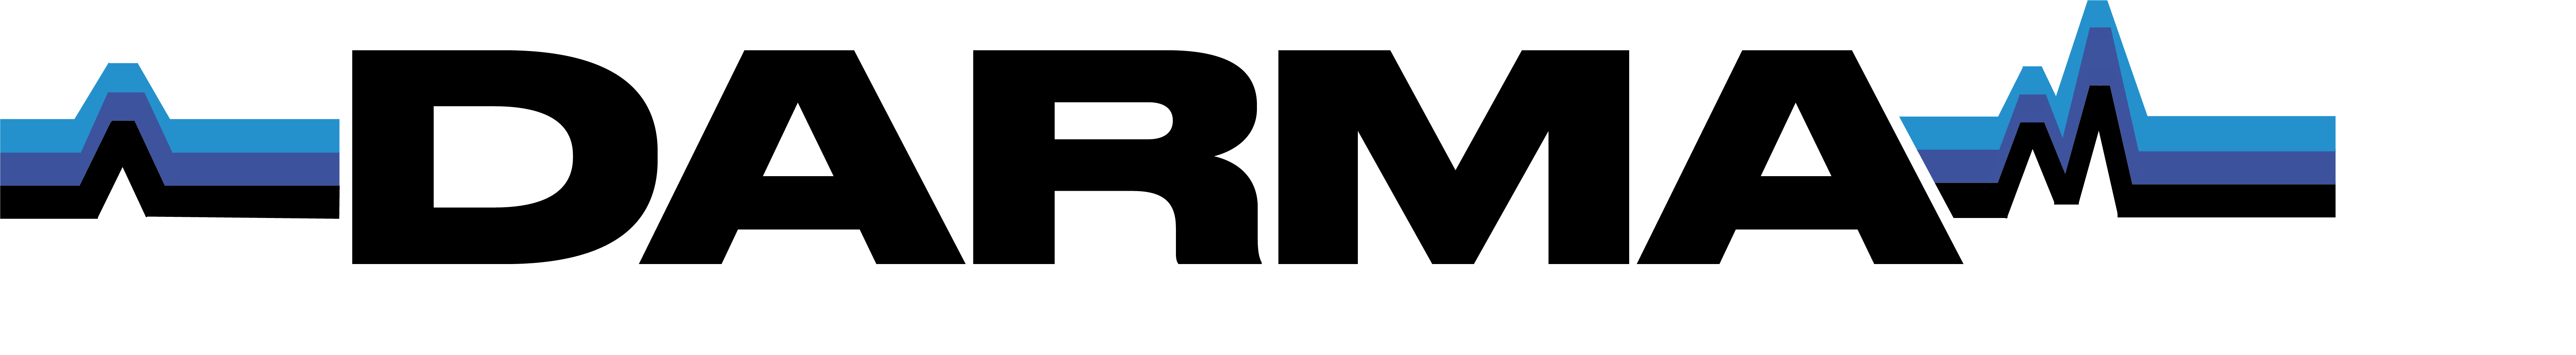

In [6]:
from IPython.display import Image

Image(filename= 'DARMA.png', width=1000, height=600)

##### Welcome to <b>DARMA</b> (<b>D</b>etection <b>A</b>utomation of <b>R</b>otational-peaks and <b>M</b>olecular <b>A</b>ssignment). This program is tailored to be able to detect 
##### pure-rotational, transition peaks from a submm spectrum (but can be modified to fit the needs of the user) and assign them to their molecular
##### catalogues. The program allows the user to then perform a Boltzmann analysis on the previously analyzed broadband spectra or a series of narrowband
##### files for a specified molecule. This program bases alot of its infrastructure on Kelvin Lee's [PySpecTools](https://github.com/laserkelvin/PySpecTools).

##### The user should follow each step in a linear manner and input any variable(s) encapsulated by three asterids (***)

## STEP 0 [OPTIONAL]: First let's import our .lwa files to turn all scans into seperate .txt's

In [7]:
# Define a few important filepaths

# ***
BASE_DIR = 'LWA_Data/' # Filepath to all .lwa's
CAT_DIR = 'catalogues/' # Filepath to all .cat's
# ***


In [8]:
# Create a folder for every .lwa and populate with .txt for each bandpass
lwa_to_txt_batch(BASE_DIR, baseline_correct = False)


 LWA has been successfully parsed. Proceed to Step 1 to create a subdirectory for your catalogues


## STEP 1: Create a subdirectory within your catalogue folder which only contains user-defined elements

In [9]:
# Elements in experiment

# ***
elements = 'CHO'
# ***

# Creates a subdirectory for the elements in the experiment and describes its filepath

cat_path = create_element_folder(CAT_DIR, elements)


 Subdirectory of catalogues only containing CHO created. Proceed to next line to create a YAML dircetory for these catalogues.


## STEP 2: Create a YAML for catalogues to automate the peak-assignment process in STEP 5

In [10]:
# Define a file path for your new YAML file

# ***
yaml_path = "YAML/"
# ***

# Define a name for your YAML file

yaml_file_name = elements + '.yaml'

# Creates a .yaml file for peak assignment and describes filepath 

yaml_filepath = create_yaml(master_path = cat_path, yaml_path = yaml_path, yaml_file_name = yaml_file_name)


 YAML directory successfully created! Proceed to step 3.


## STEP 3: Define which data you would like to analyze. The step below will sample for the data's noise and convert the signal to SNR

###### NOTE: The user will define a low threshold for peak detection to sample the noise. 3 plots will be displayed:
###### 1.) The full spectrum with the noise region highlighted
###### 2.) The noise region zoomed in on
###### 3.) The FFT of the noise region

###### The user wants an FFT which appears somewhat flat (exemplifying Gaussian-white noise) with no large humps which could be indicative of a molecular peak being sampled within the noise. The user must find the thres_precentage which results in a region with a flat FFT and is statistically signifigant ( i.e. has a sample size greater than 100) (The program will inform you if you fall below this threshold).

In [15]:
# Give user a list of some Broadband files to define as their data parameter

get_datapaths(BASE_DIR)

Here are a list of your Broadband filepaths from your lwa's: 

	 LWA_Data/0024_625500_Broadband.txt 



In [16]:
# Define Data filepath

# ***
data = 'LWA_Data/0024_625500_Broadband.txt'
# ***

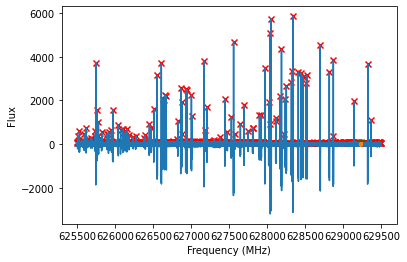

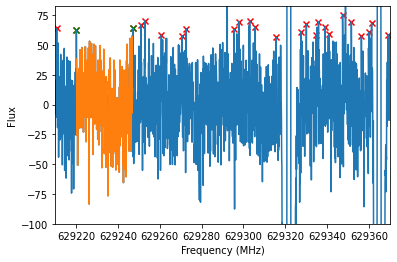

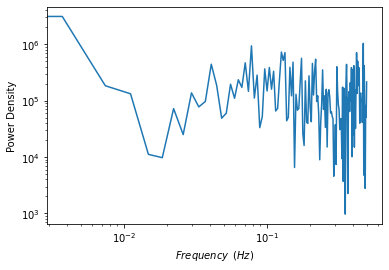


If you are content with the results from this step, proceed to step 4. If not, alter your thres_percentage parameter until you are ready to proceed.


In [20]:
# Convert data intensity to SNR

# ***
sep = '   ' # If this line fails, try sep = '\t'  
thres_percentage = 0.0095 # This value is a decimal proportion of the largest peak in the dataset. A small value is neccesary to sample the noise.
# ***

Data, rms, baseline = get_data(data, thres_percentage = thres_percentage, sep = sep)

## STEP 4: Define the number of sigma for your peak-detection threshold 

In [21]:
# Define the sigma threshold for peak detection

# ***
sigma = 3
# ***

# Define a threshold based on the sigma input above

threshold = (baseline + (rms * sigma))/abs(baseline)

Peaks = peak_find(Data, freq_col="Frequency", int_col="SNR", thres = threshold)
plot_spectrum(Data, Peaks)

FigureWidget({
    'data': [{'name': 'Experiment',
              'opacity': 0.6,
              'type': 'scatte…

<b>If you are content with the results of this step proceed to step for molecular assignment. If not, adjust your sigma parameter.</b>

## STEP 5: Cross-reference list of Peaks, using previously made YAML file, to molecular catalogues 

In [22]:
# Set Peak assignment thresholds

# ***
intensity_tolerance = -4 # log intensity
cat_max_uncertainty = 0.1 # MHz
temperature = 300 # K 
freq_offset = 1.5 # MHz
# ***

# OPTIONAL: Only input if their are special log intensity considerations for a specific molecule (Input None for both if there are no special considerations)
# *** 
special_molecule = 'CH3OH,vt=0-2'
special_intensity = -5.0
# ***

# Perform peak assignment process

assignments, dt = assign_peaks(Data, Peaks, yaml_filepath, intensity_tolerance = intensity_tolerance, 
                           cat_max_uncertainty = cat_max_uncertainty, temperature = temperature, freq_offset = freq_offset, 
                           peaks_now = False, special_molecule = special_molecule, special_intensity = special_intensity)

Processing Molecular Peak Assignments:   0%|          | 0/269 [00:00<?, ?it/s]


 Peaks found in step 4 have been assigned to their molecular catalogues! This assignment process took 00:00:33


##### <b>NOTE:</b> The next couple lines allow the user to view the assignments made in tabular form, visualize the assignments overlayed on the full spectrum, and see some statistics about the assignments.

In [23]:
# This prints how long the peak assignment process took

print(f'Time Elapsed During Peak Assignment Process: {dt}')

# prints a table out of the peak assignments 
pd.set_option ('display.max_rows', 500)
assignments = assignments.drop_duplicates()
assignments.sort_values('Frequency',ascending = True)

Time Elapsed During Peak Assignment Process: 00:00:33


,Molecule,Frequency,Catalog_Frequency,Catalog_Intensity,Intensity,Lower_State_Energy,Upper_State_Energy,Uncertainty
72,"CH3OH,vt=0-2",625510.587674,625510.49,-4.4761,313.179088,599.7367,620.601484,0.01
65,"CH3COOH,vt=1",625515.101208,625514.8081,-3.9723,95.131368,349.7071,370.572028,0.0064
176,HCCCH2OH,625559.104728,625559.9897,-3.8568,64.154129,497.3412,518.207635,0.0175
177,HCCCH2OH,625560.304824,625559.9897,-3.8568,90.319729,497.3412,518.207635,0.0175
194,O3-asym-O-18,625563.105048,625563.6585,-3.4285,77.687897,248.0632,268.929758,0.0451
195,O3-asym-O-18,625564.305144,625563.6585,-3.4285,133.628418,248.0632,268.929758,0.0451
178,HCCCH2OH,625581.00648,625582.3471,-3.8385,145.657908,480.6869,501.554081,0.0161
7,"C-13-H3CHO,vt=0,1",625587.106968,625587.7564,-3.9065,95.732921,89.2584,110.125761,0.0029
171,H2CCO,625662.513,625661.9324,-2.5532,69.868492,349.5079,370.377736,0.0333
191,HO2,625662.513,625663.7997,-2.0845,69.868492,119.437,140.306898,0.0778


In [119]:
# Plot the data with peaks a assignments

plot_spectrum(Data, Peaks, assignments)

FigureWidget({
    'data': [{'name': 'Experiment',
              'opacity': 0.6,
              'type': 'scatte…

Number of Molecular Assignments: 216


Number of Unique Assigned Peaks: 146


Number of Unique Molecules Detected: 35


Names of Unique Molecules:   (c-C3H2)CH2   C-13-H2(OH)CHO   C-13-H3CHO,vt=0,1   C-13-H3OH,vt=0,1   C2H5OH,v=0   C2H5OH   CH2(OH)C-13-HO   CH2(OH)CHO,v12=1   CH2(OH)CHO,v17=1   CH2(OH)CHO,v18=1   CH2OO   CH3C-13-HO,vt=0,1   CH3CC-13-H   CH3CHO   CH3CHOHCHO   CH3COOH,vt=0   CH3COOH,vt=1   CH3OCH3,v=0   CH3OCHO   CH3OH,vt=0-2   H2CCO   H2COH+   H2O2   HCCCH2OH   HCOCH2OH   HO2   HOC+,v2=0   O3-asym-O-18   O3-sym-O-17   a-C-13-H3CH2OH   a-CH3C-13-H2OH   c-C2H2O2   c-C2H4O-18   cis-HC-13-OO   s-H2C=CHOH


Number of Identified Molecules Detected: 20


Names of Identified Molecules:   (c-C3H2)CH2   C-13-H2(OH)CHO   C-13-H3CHO,vt=0,1   C2H5OH,v=0   C2H5OH   CH2(OH)CHO,v12=1   CH2(OH)CHO,v17=1   CH2OO   CH3C-13-HO,vt=0,1   CH3CHOHCHO   CH3OCH3,v=0   CH3OH,vt=0-2   H2CCO   HCCCH2OH   HCOCH2OH   O3-sym-O-17   a-CH3C-13-H2OH   c-C2H2O2   c-C2H4O-18   s-H2C=CHOH


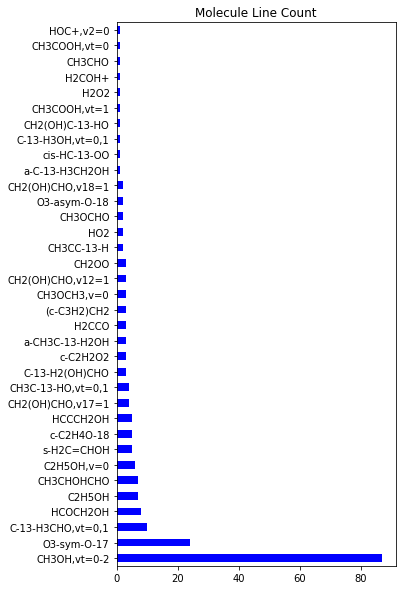

Percentage of Molecules with:

	C: 88.6 %
	H: 94.3 %
	O: 94.3 %
	D: 0.0 %
	N: 0.0 %


	Only CH: 4.8 %
	Only CHO: 78.7 %
	Only CHOD: 0.0 %
	Only CHODN: 0.0 %

Number of Unassigned Peaks: 271


In [120]:
# Call function which provides statistics regarding the assignments made with a line number threshold for identification

get_assignment_statistics(assignments, identity_threshold = 3)

# Define the unassigned peak

Unassigned_Peaks = get_unassigned_peaks(assignments, Peaks)

In [121]:
# Define the name of your output latex file

# ***
latex_save_path = 'Latex_Tables/'
latex_name = 'test'
# ***

# Save assignments in the form of a latex file

get_latex(assignments, Unassigned_Peaks, latex_name, save_path = latex_save_path)


Output latex file with assignments and unassigned peaks made. The output file has been saved in the lwa file's folder.
Proceed to Step 6 for the Boltzmann analysis.


## STEP 6: Perform a narrowband or broadband boltzman analysis

In [103]:
# Define some important filepaths

# ***
PARTITION_FUNCTION_DIR = 'Partition_Function/PartitionFunctions.txt' # Filepath to the partition values
POWER_SPECTRUM_DIR = 'Power_Correction/Power_750-1100GHz.txt' #Filepath to power spectrum
# ***    

In [70]:
# Define which lwa session we want to analyze

lwa_folder, txt_files = get_lwa_scans(BASE_DIR)

txt_fnames, sensitivities, txt_frequencies, int_factors, cat_frequencies, cat_molecule_file = find_peak_frequency_batch(txt_files, CAT_DIR, assignments, Peaks, diagnostics = False)

Which lwa session would you like to analyze?

	11182022
	Original
	03132023
	09262022
	12092022
	__pycache__
	03082023
	08052022


 03132023


Available txt files:

	0021_896797_o-H2CO.txt
	0031_943978_o-H2CO.txt
	0003_812824_p-H2CO.txt
	0028_944646_p-H2CO.txt
	0022_909500_o-H2CO.txt
	0006_874582_p-H2CO.txt
	0005_870266_p-H2CO.txt
	0015_1020747_p-H2CO.txt
	0026_1024281_o-H2CO.txt
	0017_803104_o-H2CO.txt
	0008_923581_p-H2CO.txt
	0016_770889_o-H2CO.txt
	0007_801565_p-H2CO.txt
	0024_950558_o-H2CO.txt
	0023_948447_o-H2CO.txt
	0012_964661_p-H2CO.txt
	0013_991653_p-H2CO.txt
	0010_942069_p-H2CO.txt
	0020_876642_o-H2CO.txt
	0011_947641_p-H2CO.txt
	0030_942503_o-H2CO.txt
	0000_786278_p-H2CO.txt
	0019_840268_o-H2CO.txt
	0032_945288_o-H2CO.txt
	0025_970192_o-H2CO.txt
	0027_943266_p-H2CO.txt
	0009_888622_p-H2CO.txt
	0004_855144_p-H2CO.txt
	0018_823075_o-H2CO.txt
	0014_1013704_p-H2CO.txt
	0002_799365_p-H2CO.txt
	0033_915000_Broadband.txt
	0029_945934_p-H2CO.txt
	0001_798306_p-H2CO.txt



Which molecule would you like to analyze in this .lwa file (For Broadband type "Broadband")? Broadband
What would you like to set your max peak offset to be (MHz)? 4.5


Which molecule would you like to analyze?
Available molecules:
	 CH2(OH)C-13-HO
	 CH2(OH)CHO,v=0
	 CH3OH,vt=0-2
	 H2O
	 HCOCH2OH


 CH3OH,vt=0-2


Peak at 915700.056 did not fulfill the peak threshold criteria
Peak at 916034.482752 did not fulfill the peak threshold criteria
Peak at 916035.6949614596 did not fulfill the peak threshold criteria


Extracting Broadband file information:   0%|          | 0/8 [00:00<?, ?it/s]


Center frequencies and integrations calculated! Proceed to the line below.


/Users/joshuabardwell/Desktop/NASA/LWA_Converter/Data/Example_files/03132023/Broadband/0007_916218_CH3OH,vt=0-2.txt


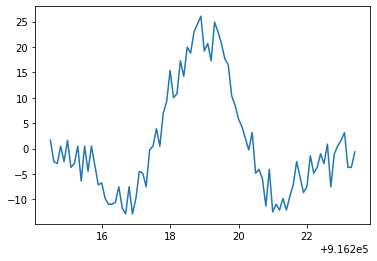

/Users/joshuabardwell/Desktop/NASA/LWA_Converter/Data/Example_files/03132023/Broadband/0003_915688_CH3OH,vt=0-2.txt


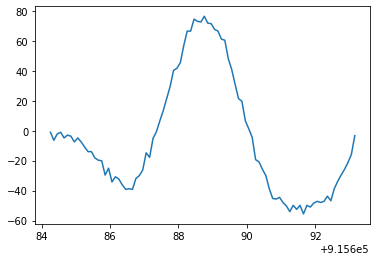

/Users/joshuabardwell/Desktop/NASA/LWA_Converter/Data/Example_files/03132023/Broadband/0006_915819_CH3OH,vt=0-2.txt


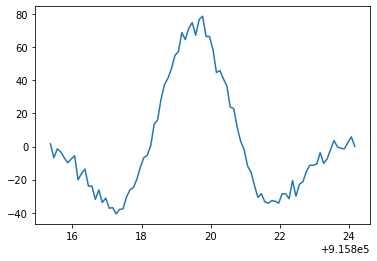

/Users/joshuabardwell/Desktop/NASA/LWA_Converter/Data/Example_files/03132023/Broadband/0005_915718_CH3OH,vt=0-2.txt


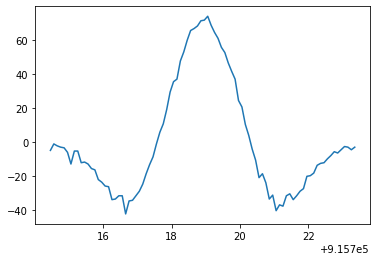

/Users/joshuabardwell/Desktop/NASA/LWA_Converter/Data/Example_files/03132023/Broadband/0001_915117_CH3OH,vt=0-2.txt


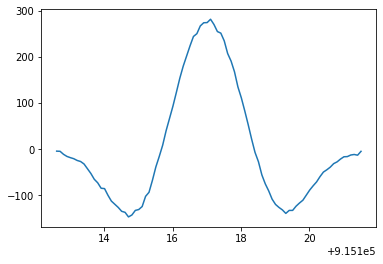

/Users/joshuabardwell/Desktop/NASA/LWA_Converter/Data/Example_files/03132023/Broadband/0004_915694_CH3OH,vt=0-2.txt


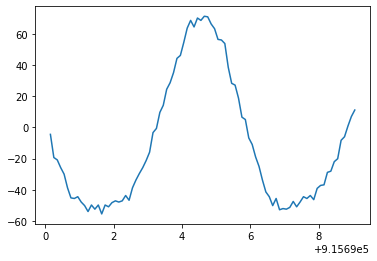

/Users/joshuabardwell/Desktop/NASA/LWA_Converter/Data/Example_files/03132023/Broadband/0002_915644_CH3OH,vt=0-2.txt


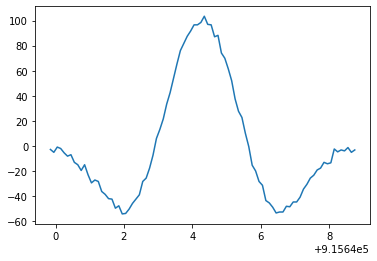

/Users/joshuabardwell/Desktop/NASA/LWA_Converter/Data/Example_files/03132023/Broadband/0000_915056_CH3OH,vt=0-2.txt


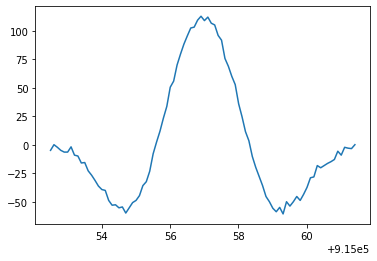

Are there any filepaths you would like to neglect during this analysis? (Type "Yes" if so) No



Great! Proceed to Boltzmann Analysis.


In [71]:
# Run this line to survey all narrowband scans and remove any 'erroneous' scans

txt_fnames, sensitivities, txt_frequencies, int_factors, cat_frequencies, cat_molecule_file = remove_narrowbands(txt_fnames, sensitivities, txt_frequencies, int_factors, cat_frequencies, cat_molecule_file)

In [104]:
# Perform the rotational analysis

rotational_analysis(txt_fnames, sensitivities, txt_frequencies, int_factors, cat_frequencies, cat_molecule_file)

590.7128389196711
3436.8923643525063
2303.7401448061337
2650.5769678114434
8973.536677930511
3847.840440901795
3657.096363707521
3658.9126874226567
30
Peak width (MHz): 4.3003439999883994
w: 1.2414023830006473
FWHM (MHz): 2.9232792154391123
30
Peak width (MHz): 5.200415999977849
w: 1.5012307887426242
FWHM (MHz): 3.5351283535487537
30
Peak width (MHz): 4.400352000026032
w: 1.270272205872069
FWHM (MHz): 2.991262453033229
30
Peak width (MHz): 4.400352000026032
w: 1.270272205872069
FWHM (MHz): 2.991262453033229
30
Peak width (MHz): 4.600367999984883
w: 1.3280118515813062
FWHM (MHz): 3.127228928142326
30
Peak width (MHz): 5.200415999977849
w: 1.5012307887426242
FWHM (MHz): 3.5351283535487537
30
Peak width (MHz): 4.50035999994725
w: 1.2991420287098845
FWHM (MHz): 3.059245690548209
30
Peak width (MHz): 4.600367999984883
w: 1.3280118515813062
FWHM (MHz): 3.127228928142326
Success
182    4.5685
Name: lg(Q(300)), dtype: float64
found
[916218.808]
916218.808
[916218.808, 915688.748, 915819.878, 9